# Notebook for making supplementary figures

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue']})
#rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)
import re

# Finding recurrent mutations (DNA level)

Generate list of tuples containing [gene_name, mutation_info] and sort with np.unique() on this list of tuples to find unique mutations. 

For INS/DEL, include start/end site.

Coincidently, create a list of [index in database] and [patient barcodes] to allow for further filtration based on whether there are multiple patient samples.

In [2]:
filepath = '/Volumes/Sam_G_SSD/2020-06-16-MSK-IMPACT_EDITED.txt'
impact_data = pd.read_csv(filepath, sep='\t')

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_30481/836307472.py:2: DtypeWarning: Columns (45,48,88) have mixed types. Specify dtype option on import or set low_memory=False.
  impact_data = pd.read_csv(filepath, sep='\t')


In [3]:
#starting with SNPs
def recurrence_quant(variant_type):
    "choose SNP, DEL, INS, DNP, or ONP"
    snps = impact_data[impact_data['Variant_Type']==variant_type]

    idx = list(snps.index)
    barcode_list = list(snps['Tumor_Sample_Barcode'])
    patient_barcode = [i[:9] for i in barcode_list]

    gene_list = list(snps['Hugo_Symbol'])
    start = list(snps['Start_Position'])
    end = list(snps['End_Position'])
    allele = list(snps['Tumor_Seq_Allele2'])
    ref_allele = list(snps['Reference_Allele'])
    hgvsp = list(snps['HGVSp'])

    comb = [[gene_list[i], start[i], end[i], ref_allele[i], allele[i], hgvsp[i]] for i in range(len(gene_list))]

    uniq, counts= np.unique(comb, axis=0, return_counts=True)

    str_version_comb = []
    for i in comb:
        j = []
        for k in i:
            st = str(k)
            j.append(st)
        str1 = j[0] + j[1] + j[2] + j[3]
        str_version_comb.append(str1)

    str_version_uniq = []
    for i in uniq:
        j = []
        for k in i:
            st = str(k)
            j.append(st)
        str1 = j[0] + j[1] + j[2] + j[3]
        str_version_uniq.append(str1)

    pat_bar_list = [] #holds which patient barcodes correspond to mutation 
    index_list = [] #holds which indexes (in MSK IMPACT) correspond to mutation 

    for i in str_version_uniq:
        found_idx = np.where(np.array(str_version_comb)==i)[0]

        id1 = []
        bar = []
        for k in found_idx:
            bar.append(patient_barcode[k])
            id1.append(idx[k])
        pat_bar_list.append(bar)
        index_list.append(id1)

    ####save firts then this section
    true_counts = []
    unique_barcodes = []
    for i in pat_bar_list:
        uniq_bars, bar_counts = np.unique(i, return_counts=True)
        unique_barcodes.append(uniq_bars)

        subtract = np.sum(bar_counts - np.ones(len(uniq_bars))) #e.g. [2,1]-[1,1] = 1 > should subtract one from total
        true = np.sum(bar_counts)-subtract
        true_counts.append(true)


    df_recur = pd.DataFrame(uniq[:,0], columns=['gene'])
    df_recur['start'] = uniq[:,1]
    df_recur['end'] = uniq[:,2]
    df_recur['ref_allele'] = uniq[:,3]
    df_recur['tumor_allele'] = uniq[:,4]
    df_recur['AA_consequence']=uniq[:,5]

    df_recur['num_occur'] = true_counts
    df_recur['barcodes'] = unique_barcodes
    df_recur['indeces'] = index_list

    return df_recur

In [6]:
#these tables are provided in the public dropbox repository
#in the "recurrent mutant tables" folder

variant_type_list=['SNP','DNP', 'ONP', 'DEL', 'INS']
for variant_type in variant_type_list:
    df_recur = recurrence_quant(variant_type)
    name = variant_type + '_recurrent_dna.csv'
    print(name)
    df_recur.to_csv(name)

DNP_recurrent_dna.csv
ONP_recurrent_dna.csv
DEL_recurrent_dna.csv
INS_recurrent_dna.csv


## Making figures with all reccurrent mutants quantified, then breaking down by each mutant type (with correct colors)

In [5]:
filepath = '/Users/samgould/Desktop/FSR Lab/2022-05-11/'
snp_rec = pd.read_csv(filepath+ 'recurrent_DNA_SNP_fullinfo.csv')
dnp_rec = pd.read_csv(filepath+'DNP_recurrent_dna.csv')
onp_rec = pd.read_csv(filepath+'ONP_recurrent_dna.csv')
del_rec = pd.read_csv(filepath+'DEL_recurrent_dna.csv')
ins_rec = pd.read_csv(filepath+'INS_recurrent_dna.csv')

In [6]:
dnp_rec = dnp_rec.drop(['Unnamed: 0'], axis=1)
onp_rec = onp_rec.drop(['Unnamed: 0'], axis=1)
del_rec = del_rec.drop(['Unnamed: 0'], axis=1)
ins_rec = ins_rec.drop(['Unnamed: 0'], axis=1)

In [7]:
result = pd.concat([snp_rec, dnp_rec, onp_rec, del_rec, ins_rec])

In [8]:
result

,gene,start,end,ref_allele,tumor_allele,num_occur,AA_consequence,barcodes,indeces
0,ABL1,133710842,133710842,G,C,1.0,p.Glu3Asp,['P-0001539'],[296224]
1,ABL1,133710843,133710843,A,G,1.0,p.Ile4Val,['P-0037077'],[200589]
2,ABL1,133710859,133710859,T,C,1.0,p.Val9Ala,['P-0004379'],[119674]
3,ABL1,133710861,133710861,G,A,1.0,p.Gly10Ser,['P-0003900'],[118210]
4,ABL1,133710873,133710873,A,G,1.0,p.Lys14Glu,['P-0029972'],[244050]
...,...,...,...,...,...,...,...,...,...
10046,ZRSR2,15821895,15821896,-,A,1.0,p.Arg99ThrfsTer46,['P-0036284'],[204868]
10047,ZRSR2,15841069,15841070,-,TG,1.0,p.Pro385LeufsTer?,['P-0008689'],"[339434, 407057]"
10048,ZRSR2,15841123,15841124,-,G,2.0,p.Lys405GlufsTer23,['P-0025100' 'P-0041067'],"[153392, 210519, 241901]"
10049,ZRSR2,15841230,15841231,-,AGCCGG,5.0,p.Ser447_Arg448dup,['P-0012496' 'P-0016427' 'P-0021403' 'P-002675...,"[233084, 254504, 306632, 405001, 409126]"


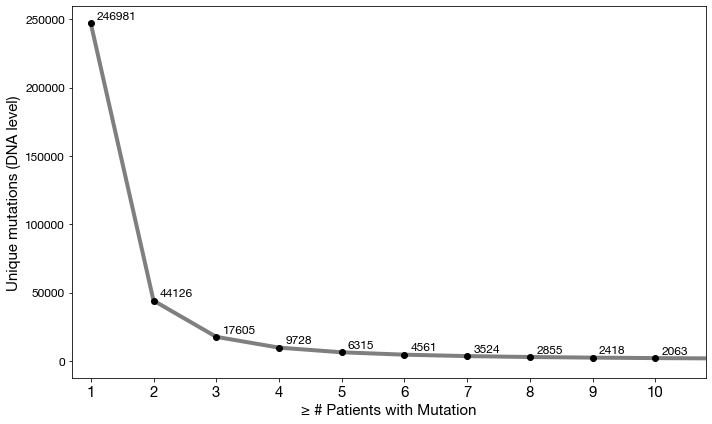

In [9]:
#double check that this is correct....
g = np.array(result['num_occur'])
unique, counts = np.unique(g, return_counts=True)
cum_sum = [sum(counts[i:]) for i in range(len(counts))] 

plt.figure(figsize=(10,6))
plt.plot(unique, cum_sum, linewidth=4, alpha=0.5, c='black')
plt.scatter(unique, cum_sum, c='black')
plt.xlabel('≥ # Patients with Mutation', fontsize=15)
plt.ylabel('Unique mutations (DNA level)', fontsize=15)
plt.xlim(0.7,10.8)
plt.xticks(range(1,11),fontsize=15)
plt.yticks(fontsize=12)
for i in range(10):
    plt.text(unique[i]+.1, cum_sum[i]+3000, cum_sum[i], fontsize=12)

plt.tight_layout()
#plt.savefig('recurrent_all_muts.png', dpi=250)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


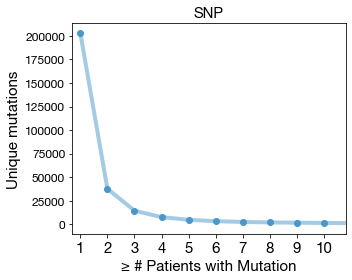

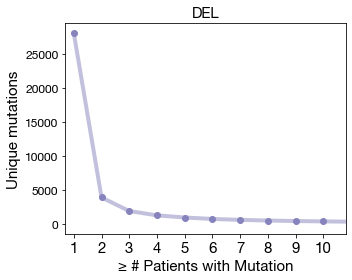

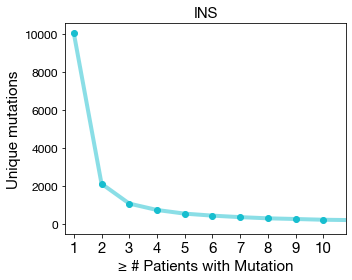

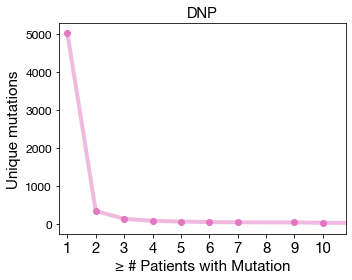

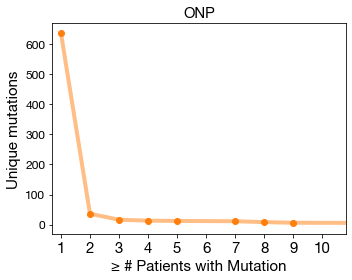

In [48]:
c_list = [plt.cm.Blues(0.6), plt.cm.Purples(0.6), 'tab:cyan', 'tab:pink', 'tab:orange']
frame = [snp_rec, del_rec, ins_rec, dnp_rec, onp_rec]
title_list = ['SNP', 'DEL', 'INS', 'DNP', 'ONP']
for idx, val in enumerate(frame):
    g = np.array(val['num_occur'])
    unique, counts = np.unique(g, return_counts=True)
    cum_sum = [sum(counts[i:]) for i in range(len(counts))] 

    plt.figure(figsize=(5,4))
    plt.plot(unique, cum_sum, linewidth=4, alpha=0.5, c=c_list[idx])
    plt.scatter(unique, cum_sum, c=c_list[idx])
    plt.xlabel('≥ # Patients with Mutation', fontsize=15)
    plt.ylabel('Unique mutations', fontsize=15)
    plt.xlim(0.7,10.8)
    plt.xticks(range(1,11),fontsize=15)
    plt.yticks(fontsize=12)
    plt.title(title_list[idx], fontsize=15)
    
    

    plt.tight_layout()
         

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

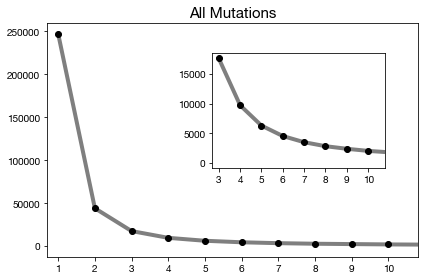

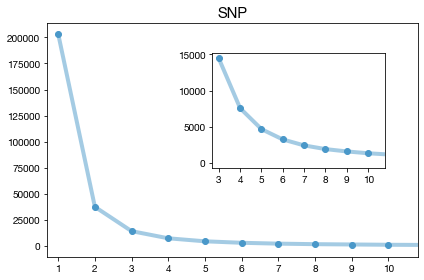

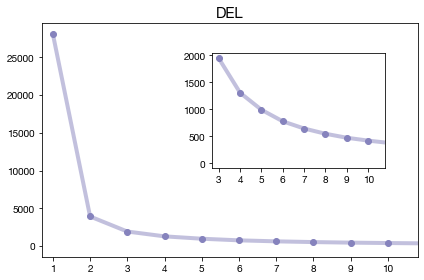

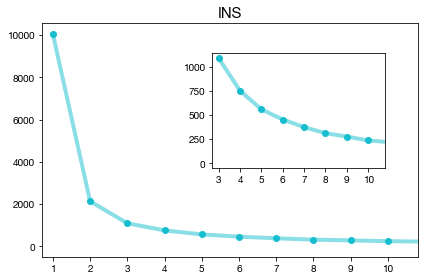

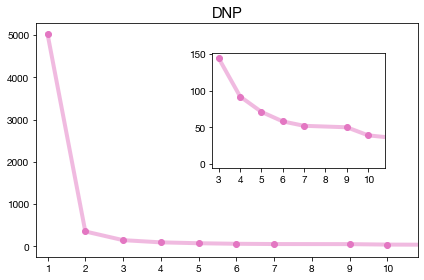

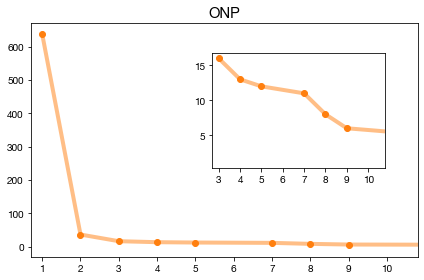

In [19]:
c_list = ['black', plt.cm.Blues(0.6), plt.cm.Purples(0.6), 'tab:cyan', 'tab:pink', 'tab:orange']
frame = [result, snp_rec, del_rec, ins_rec, dnp_rec, onp_rec]
title_list = ['All Mutations', 'SNP', 'DEL', 'INS', 'DNP', 'ONP']
for idx, val in enumerate(frame):
    g = np.array(val['num_occur'])
    unique, counts = np.unique(g, return_counts=True)
    cum_sum = [sum(counts[i:]) for i in range(len(counts))] 

    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(unique, cum_sum, linewidth=4, alpha=0.5, c=c_list[idx])
    ax1.scatter(unique, cum_sum, c=c_list[idx])
    ax1.set_xlabel('≥ # Patients with Mutation', fontsize=15)
    ax1.set_ylabel('Unique mutations', fontsize=15)
    ax1.set_xlabel('', fontsize=15)
    ax1.set_ylabel('', fontsize=15)
    ax1.set_xlim(0.7,10.8)
    ax1.set_xticks(range(1,11),fontsize=15)
    #ax1.set_xticklabels(['','','','','','','','','',''])


    #ax1.set_yticklabels(fontsize=12)
    
    ax1.set_title(title_list[idx], fontsize=15)
    
    

    fig.tight_layout()


#fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.5, 0.4, 0.4, 0.4]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.plot(unique[2:], cum_sum[2:], linewidth=4, alpha=0.5, c=c_list[idx])
    ax2.scatter(unique[2:], cum_sum[2:], c=c_list[idx])
    #ax2.set_xlabel('≥ # Patients with Mutation', fontsize=15)
    #ax2.set_ylabel('Unique mutations', fontsize=15)
    ax2.set_xlim(2.7,10.8)
    ax2.set_xticks(range(3,11),fontsize=15)
    #ax2.set_xticklabels(['','','','','','','',''])
    
    #fig.savefig(title_list[idx] + '_nolabels.png', dpi=250)

#ax1.plot(range(10), color='red')
    #ax2.plot(range(6)[::-1], color='green')

## Generating Figures Based on recurrent mutations
### Base Editing

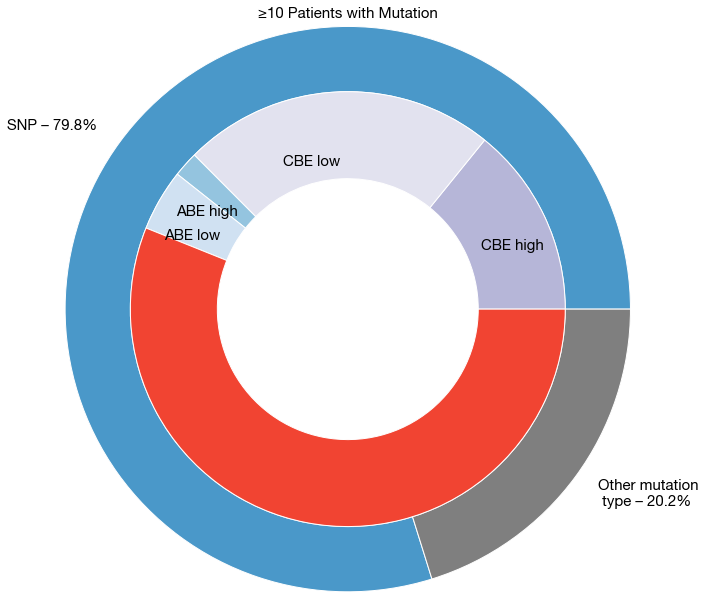

In [34]:
###
min_patients=10

atleast2 = result[result['num_occur']>=min_patients]
index2 = np.array(atleast2['indeces'])
idx_list = []
for i in index2: #lazy way of doing this...
    ints = re.findall(r'\d+', i)
    for k in ints:
        idx_list.append(int(k))

idx_list = np.unique(idx_list)

#filtered BE figure
var_types = np.array(impact_data['Variant_Type'])
var_types = [var_types[i] for i in idx_list]
val, cou = np.unique(np.array(var_types), return_counts=True)
snp_idx = list(val).index('SNP')
num_snp = cou[snp_idx]
mut_types=cou


#loading in coverage information
filepath = '/Volumes/Sam_G_SSD/BE coverage quant NGG/'
CBEproto = np.load(filepath + 'CBE_proto.npy')
CBEideal = np.load(filepath + 'CBE_ideal.npy')
ABEproto = np.load(filepath + 'ABE_proto.npy')
ABEideal = np.load(filepath + 'ABE_ideal.npy')

CBEproto = [CBEproto[i] for i in idx_list]
CBEideal = [CBEideal[i] for i in idx_list]
ABEproto = [ABEproto[i] for i in idx_list]
ABEideal = [ABEideal[i] for i in idx_list]


perc_snp = np.round((100*(num_snp/sum(mut_types))), 1)
perc_non_snp = np.round(100-perc_snp, 1)

# Make data: I have 3 groups and 7 subgroups
group_names=['SNP – ' + str(perc_snp)+ '%', 'Other mutation \n type – ' + str(perc_non_snp)+ '%'] #
#group_names=['', '']
snp_unrecorded = []
group_size=[num_snp-len(snp_unrecorded), sum(mut_types)-num_snp-len(snp_unrecorded)] #excluding missing SNPs
subgroup_names=['CBE high', 'CBE low', 'ABE high', 'ABE low', '']
#subgroup_names=['', '', '', '', '']



subgroup_size = [sum(CBEideal), sum(CBEproto)-sum(CBEideal), sum(ABEideal), sum(ABEproto)-sum(ABEideal), sum(mut_types)-sum(CBEproto)-sum(ABEproto)-len(snp_unrecorded)]
#subgroup_size=[4,3,5,6,5,10,5,5,4,6]
 
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]

# First Ring (outside)
fig, ax = plt.subplots(figsize=(12,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray', c(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.68, colors=[d(0.4), d(0.2), a(0.4), a(0.2), b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
# show it
plt.title("≥" + str(min_patients) + ' Patients with Mutation', pad=20, fontsize=15)
#plt.tight_layout()

plt.savefig('patients_BE_label_min'+str(min_patients)+'.png', dpi=250)

plt.show()
#print(100*(subgroup_size/sum(subgroup_size)))

In [35]:
min_patients=range(10)
normed = []
for min_patients in range(1,11):
    atleast2 = result[result['num_occur']>=min_patients]
    index2 = np.array(atleast2['indeces'])
    idx_list = []
    for i in index2: #lazy way of doing this...
        ints = re.findall(r'\d+', i)
        for k in ints:
            idx_list.append(int(k))

    idx_list = np.unique(idx_list)

    #filtered BE figure
    var_types = np.array(impact_data['Variant_Type'])
    var_types = [var_types[i] for i in idx_list]
    val, cou = np.unique(np.array(var_types), return_counts=True)
    snp_idx = list(val).index('SNP')
    num_snp = cou[snp_idx]
    mut_types=cou

    #loading in coverage information
    filepath = '/Volumes/Sam_G_SSD/BE coverage quant NGG/'
    CBEproto = np.load(filepath + 'CBE_proto.npy')
    CBEideal = np.load(filepath + 'CBE_ideal.npy')
    ABEproto = np.load(filepath + 'ABE_proto.npy')
    ABEideal = np.load(filepath + 'ABE_ideal.npy')

    CBEproto = [CBEproto[i] for i in idx_list]
    CBEideal = [CBEideal[i] for i in idx_list]
    ABEproto = [ABEproto[i] for i in idx_list]
    ABEideal = [ABEideal[i] for i in idx_list]

    a1 = [sum(CBEideal), sum(ABEideal), sum(CBEproto)-sum(CBEideal), sum(ABEproto)-sum(ABEideal)]
    a1_normed = np.asarray(a1)/sum(mut_types)
    normed.append(a1_normed)

In [179]:
np.array(normed)[:,0]

array([0.33820775, 0.43876229, 0.4347875 , 0.41601272, 0.40330407,
       0.39648356, 0.39313658, 0.39346129, 0.39507892, 0.39558071])

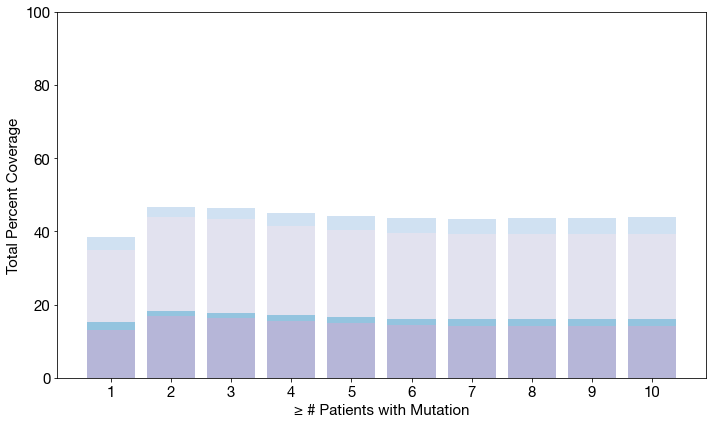

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
colors=[d(0.4), d(0.2), a(0.4), a(0.2)]
plt.bar(range(1,11), 100*np.array(normed)[:,0], label='CBE high', color=colors[0])
plt.bar(range(1,11), 100*np.array(normed)[:,1], color=colors[2], bottom=100*np.array(normed)[:,0], label='ABE high')
plt.bar(range(1,11), 100*np.array(normed)[:,2], color=colors[1], bottom=100*np.array(normed)[:,0]+100*np.array(normed)[:,1], label='CBE low')
plt.bar(range(1,11), 100*np.array(normed)[:,3], color=colors[3], bottom=100*np.array(normed)[:,0]+100*np.array(normed)[:,1]+100*np.array(normed)[:,2], label='ABE low')




#plt.legend(fontsize=15)
#plt.title('flank size = +/- 0', fontsize=15)
plt.xticks(range(1,11),fontsize=15);
plt.yticks(fontsize=15);
#ax.set_xticklabels(['','','','','','','','','',''])
#ax.set_yticklabels(['','','','','',''])
plt.ylabel('Total Percent Coverage', fontsize=15)
plt.xlabel('≥ # Patients with Mutation', fontsize=15)
#plt.ylabel('', fontsize=15)
#plt.xlabel('', fontsize=15)


#for i in range(len(mut_types[0:6])):
#    plt.text(i, homologous[i] + non_homologous[i]+5000, str(np.round(100*(homologous[i]/(homologous[i] + non_homologous[i])), 1)) + '%', ha = 'center', fontsize=13)

plt.ylim(0,100)
plt.tight_layout() 
#plt.savefig('BE_recur_bar_NGG_nolabels.png', dpi=250)

### Prime Editing

In [42]:
filepath = '/Volumes/Sam_G_SSD/PE coverage quant NGG/MSK_PE_coverage_NGG_rt_1to50.npy'
cover_list = np.load(filepath)


In [67]:
snps_pe = 0
non_snps_pe = 0

g = cover_list[rt_len] #= RT template length of 15
g = [g[i] for i in idx_list]
var_types = np.array(impact_data['Variant_Type'])
var_types = [var_types[i] for i in idx_list]

for i in range(len(idx_list)):
    if var_types[i]=='SNP':
        if g[i]==1:
            snps_pe +=1
        else:
            continue
    else:
        if g[i]==1:
            non_snps_pe +=1
        else:
            continue
        

In [66]:
(snps_pe+non_snps_pe)/(sum(mut_types[0:]))

0.9610647972716938

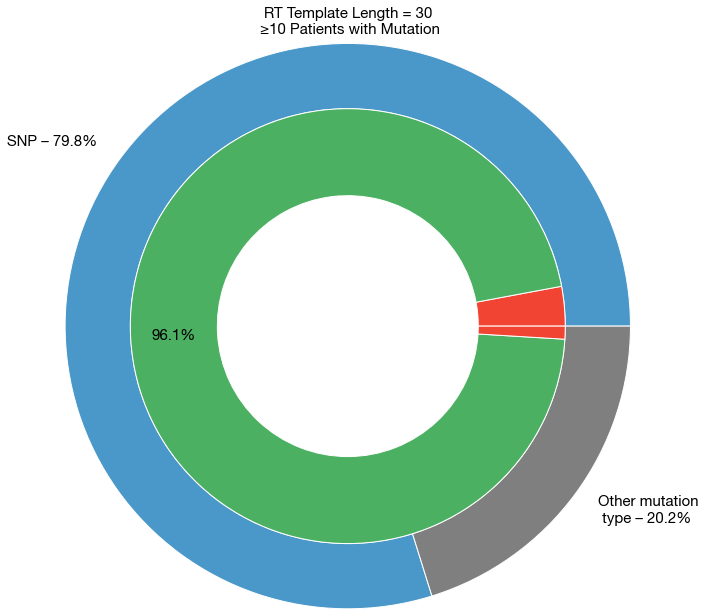

In [76]:
SNP = np.asarray(impact_data[impact_data['Variant_Type']=='SNP'].index)

rt_len = 30-1

g = cover_list[rt_len] #= RT template length of 15

min_patients=10

atleast2 = result[result['num_occur']>=min_patients]
index2 = np.array(atleast2['indeces'])
idx_list = []
for i in index2: #lazy way of doing this...
    ints = re.findall(r'\d+', i)
    for k in ints:
        idx_list.append(int(k))

idx_list = np.unique(idx_list)

#filtered BE figure
var_types = np.array(impact_data['Variant_Type'])
var_types = [var_types[i] for i in idx_list]
val, cou = np.unique(np.array(var_types), return_counts=True)
snp_idx = list(val).index('SNP')
num_snp = cou[snp_idx]
mut_types=cou

# Make data: I have 3 groups and 7 subgroups
perc_snp = np.round((100*(num_snp/sum(mut_types))), 1)
perc_non_snp = np.round(100-perc_snp, 1)

# Make data: I have 3 groups and 7 subgroups
group_names=['SNP – ' + str(perc_snp)+ '%', 'Other mutation \n type – ' + str(perc_non_snp)+ '%'] #
#group_names=['',''] #


group_size = [num_snp, sum(mut_types[0:])-num_snp]

#subgroup_names=['editable', 'non-editable', 'non-editable','editable']

    
#sum1 = ONP1[rt_len]+DNP1[rt_len]+INS1[rt_len]+ DEL1[rt_len] + TNP1[rt_len]

g = [g[i] for i in idx_list]


snps_pe = 0
non_snps_pe = 0

g = cover_list[rt_len] #= RT template length of 15
g = [g[i] for i in idx_list]
var_types = np.array(impact_data['Variant_Type'])
var_types = [var_types[i] for i in idx_list]

for i in range(len(idx_list)):
    if var_types[i]=='SNP':
        if g[i]==1:
            snps_pe +=1
        else:
            continue
    else:
        if g[i]==1:
            non_snps_pe +=1
        else:
            continue

subgroup_size = [num_snp - snps_pe, snps_pe+ non_snps_pe, sum(mut_types[0:]) - num_snp - non_snps_pe]
                 


perc= np.round(100*np.asarray(subgroup_size)/sum(subgroup_size),1)
subgroup_names=['', str(perc[1])+'%', '']
#subgroup_names=['','', '']


    
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(12,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray', c(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[ b(0.6),c(0.6), b(0.6),c(0.6), b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

ax.set_title('RT Template Length = ' + str(rt_len+1) + '\n ≥' + str(min_patients) + ' Patients with Mutation', pad=20, fontsize=15)
# show it
#plt.tight_layout()
#plt.savefig('patients_PE_NGG_min_nolabel_'+str(min_patients)+'.png', dpi=250)


plt.show()


In [80]:
SNP = np.asarray(impact_data[impact_data['Variant_Type']=='SNP'].index)

g = cover_list[30-1] #= RT template length of 15

cover = []
for min_patients in range(1,11):

    atleast2 = result[result['num_occur']>=min_patients]
    index2 = np.array(atleast2['indeces'])
    idx_list = []
    for i in index2: #lazy way of doing this...
        ints = re.findall(r'\d+', i)
        for k in ints:
            idx_list.append(int(k))

    idx_list = np.unique(idx_list)

    #filtered BE figure
    var_types = np.array(impact_data['Variant_Type'])
    var_types = [var_types[i] for i in idx_list]
    val, cou = np.unique(np.array(var_types), return_counts=True)
    snp_idx = list(val).index('SNP')
    num_snp = cou[snp_idx]
    mut_types=cou
    
    g = cover_list[30-1] #= RT template length of 15
    g = [g[i] for i in idx_list]

    subgroup_size = [sum(g), sum(mut_types[0:])-sum(g)]
    perc= 100*np.asarray(subgroup_size)/sum(subgroup_size)

    cover.append(perc[0])
    
    

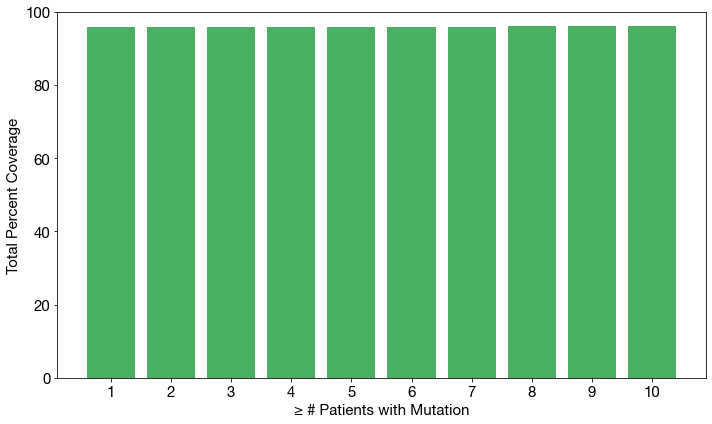

In [88]:
fig, ax = plt.subplots(figsize=(10,6))
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]

plt.bar(range(1,11), cover,  color=c(0.6))


#plt.title('flank size = +/- 0', fontsize=15)
plt.xticks(range(1,11),fontsize=15);
#ax.set_xticklabels(['','','','','','','','','',''])
#ax.set_yticklabels(['','','','','',''])


plt.yticks(fontsize=15);
plt.ylabel('Total Percent Coverage', fontsize=15)
plt.xlabel('≥ # Patients with Mutation', fontsize=15)
#plt.ylabel('', fontsize=15)
#plt.xlabel('', fontsize=15)



#for i in range(len(mut_types[0:6])):
#    plt.text(i, homologous[i] + non_homologous[i]+5000, str(np.round(100*(homologous[i]/(homologous[i] + non_homologous[i])), 1)) + '%', ha = 'center', fontsize=13)

plt.ylim(0,100)
plt.tight_layout() 
#plt.savefig('PE_bar_NGG_nolabels.png',dpi=250)



# Now looking at different orthologous recurrent mutations 


In [91]:
flank_size=0
i = flank_size
path = '/Volumes/Sam_G_SSD/'
df = pd.read_csv(path+'flanksize_' + str(i) +'.csv')
mut_types = np.unique(df['variant_type'])


filepath = '/Volumes/Sam_G_SSD/BE coverage quant NGG/'
CBEproto = np.load(filepath + 'CBE_proto.npy')
CBEideal = np.load(filepath + 'CBE_ideal.npy')
ABEproto = np.load(filepath + 'ABE_proto.npy')
ABEideal = np.load(filepath + 'ABE_ideal.npy')

df['CBEproto']=CBEproto
df['CBEideal']=CBEideal
df['ABEproto']=ABEproto
df['ABEideal']=ABEideal
df['BE_total'] = CBEproto+ABEproto

filepath = '/Volumes/Sam_G_SSD/PE coverage quant NGG/MSK_PE_coverage_NGG_rt_1to50.npy'
cover_list = np.load(filepath)
df['PEcover_rt30'] = cover_list[29]

In [92]:
df

,Unnamed: 0,homologous,non_homologous,coding_mutations,non_coding_mutations,excluded_mutations,aa_concordant,dna_concordant,original_aa,new_aa_h,new_aa_m,variant_type,CBEproto,CBEideal,ABEproto,ABEideal,BE_total,PEcover_rt30
0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,none,none,none,SNP,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,S,none,none,DEL,0.0,0.0,0.0,0.0,0.0,1.0
2,2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,M,T,T,SNP,0.0,0.0,1.0,0.0,1.0,1.0
3,3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,none,none,none,INS,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,Q,none,none,DEL,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422817,422817,1.0,0.0,1.0,0.0,0.0,0.0,0.0,S,C,S,SNP,0.0,0.0,0.0,0.0,0.0,1.0
422818,422818,1.0,0.0,1.0,0.0,0.0,0.0,0.0,P,A,G,SNP,0.0,0.0,0.0,0.0,0.0,1.0
422819,422819,1.0,0.0,1.0,0.0,0.0,1.0,1.0,P,L,L,SNP,1.0,0.0,0.0,0.0,1.0,1.0
422820,422820,0.0,0.0,0.0,1.0,0.0,0.0,0.0,none,none,none,SNP,0.0,0.0,0.0,0.0,0.0,1.0


## Prime Editing orthology in recurrent mutations

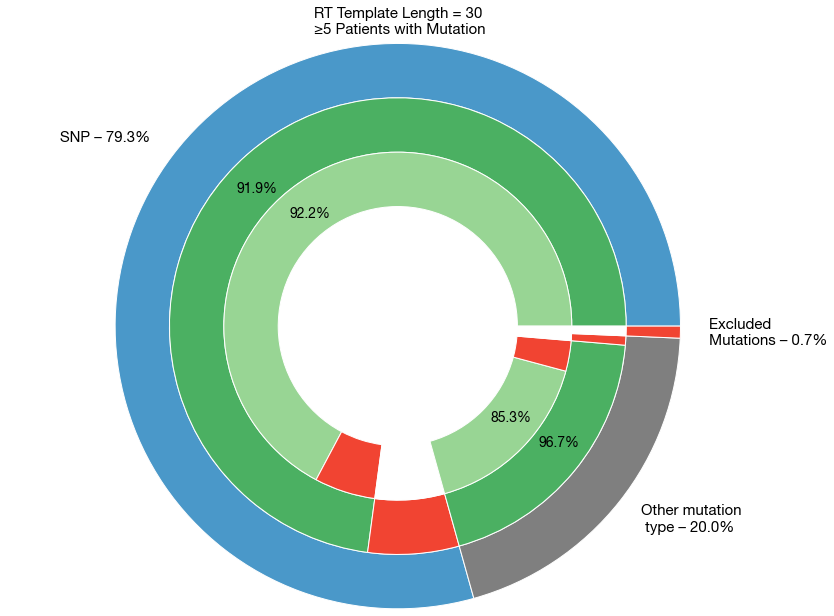

In [99]:
##input parameter________________________________________________________________

min_patients=5

##generating dataframe________________________________________________________________

atleast2 = result[result['num_occur']>=min_patients]
index2 = np.array(atleast2['indeces'])
idx_list = []
for i in index2: #lazy way of doing this...
    ints = re.findall(r'\d+', i)
    for k in ints:
        idx_list.append(int(k))

idx_list = np.unique(idx_list)

recur_binary = np.zeros(len(df))
for i in idx_list:
    recur_binary[i]+=1
    
df['recur']=recur_binary

recurrent = df[df['recur']==1]

###plotting________________________________________________________________
snps = recurrent[recurrent['variant_type']=='SNP']
snps_true = snps[snps['excluded_mutations']==0]

non_snps = recurrent[recurrent['variant_type']!='SNP']
non_snps_true = non_snps[non_snps['excluded_mutations']==0]

excl = sum(recurrent['excluded_mutations'])
snps_perc = np.round(100*len(snps_true)/len(recurrent), 1)
excl_perc = np.round(100*excl/len(recurrent), 1)
non_snps_perc = np.round(100*(len(recurrent)-excl-len(snps_true))/len(recurrent), 1)

group_names=['SNP – ' + str(snps_perc) + '%', 'Other mutation \n type – ' + str(non_snps_perc) + '%', 'Excluded \nMutations – '+ str(excl_perc) + '%'] #
#group_names=['','','']


snp_unrecorded = []
group_size=[len(snps_true), len(non_snps_true), excl] #excluding missing SNPs

snps_coding = sum(np.array(snps_true['coding_mutations']))
snp_noncoding = sum(np.array(snps_true['non_coding_mutations']))

non_snps_coding = sum(np.array(non_snps_true['coding_mutations']))
non_snps_noncoding = sum(np.array(non_snps_true['non_coding_mutations']))

subgroup_size = [snps_coding,snp_noncoding, non_snps_coding,non_snps_noncoding, excl]
snpprct = np.round(100*snps_coding/len(snps_true), 1)
nsnpprct = np.round(100*non_snps_coding/len(non_snps_true), 1)
subgroup_names=[str(snpprct) + '%', '', str(nsnpprct) + '%', '', '']
#subgroup_names=['', '', '', '', '']



# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray',b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.25, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.25, labels=subgroup_names, labeldistance=0.80, colors=[c(0.6), b(0.6), c(0.6), b(0.6), 'white'], textprops={'fontsize': 14})
plt.setp( mypie2, width=0.25, edgecolor='white')
plt.margins(0,0)

#third ring (smalles)
homo_snp = snps_true[snps_true['homologous']==1]
homo_and_model = homo_snp[homo_snp['PEcover_rt30']==1]
homo_nonsnp = non_snps_true[non_snps_true['homologous']==1]
homo_and_model_ns = homo_nonsnp[homo_nonsnp['PEcover_rt30']==1]

snps_homo = sum(np.array(homo_and_model['homologous']))
snps_nonhomo = snps_coding - snps_homo
non_snps_homo = sum(np.array(homo_and_model_ns['homologous']))
non_snps_nonhomo = non_snps_coding - non_snps_homo

snp_perc1 = np.round(100*snps_homo/(snps_homo+snps_nonhomo),1)
non_snp_perc1 = np.round(100*non_snps_homo/(non_snps_homo+non_snps_nonhomo),1)

subgroup_size2 = [snps_homo, snps_nonhomo, snp_noncoding,  non_snps_homo, non_snps_nonhomo, non_snps_noncoding, excl]
subgroup_names2=[str(snp_perc1) + '%', '','', str(non_snp_perc1) + '%', '','', '']
#subgroup_names2=['', '','', '', '','', '']




mypie3, _ = ax.pie(subgroup_size2, radius=1.3-0.5, labels=subgroup_names2, labeldistance=0.75, colors=[c(0.4), b(0.6),'white', c(0.4), b(0.6), 'white', 'white'], textprops={'fontsize': 14})
plt.setp( mypie3, width=0.25, edgecolor='white')
plt.margins(0,0)
#plt.legend()
 
# show it
#plt.tight_layout()
ax.set_title('RT Template Length = 30\n ≥' + str(min_patients) + ' Patients with Mutation', pad=20, fontsize=15)


plt.show()

#fig.savefig('PE_donut_recur_nolabel' + str(min_patients)+'.png', dpi=250)



## Base editing orthology in recurrent mutations

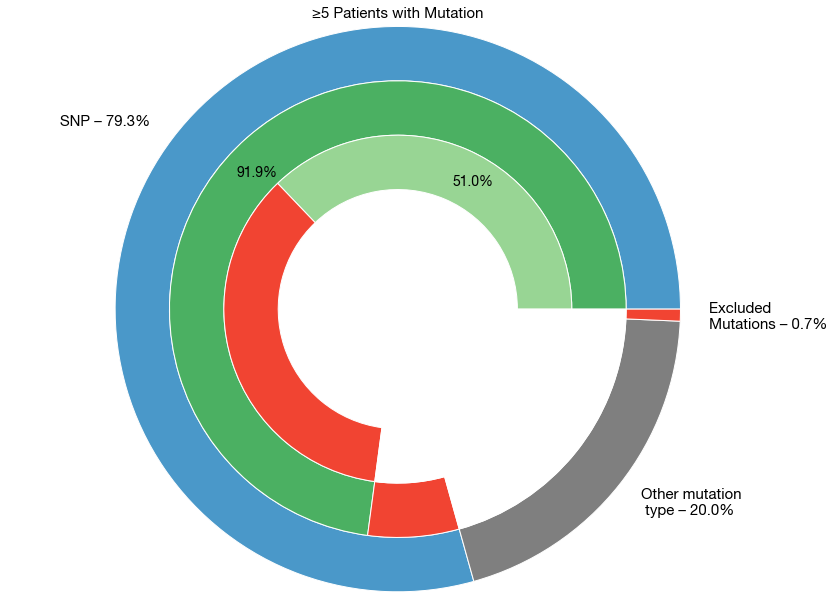

In [104]:
##generating dataframe
min_patients=5

atleast2 = result[result['num_occur']>=min_patients]
index2 = np.array(atleast2['indeces'])
idx_list = []
for i in index2: #lazy way of doing this...
    ints = re.findall(r'\d+', i)
    for k in ints:
        idx_list.append(int(k))

idx_list = np.unique(idx_list)

recur_binary = np.zeros(len(df))
for i in idx_list:
    recur_binary[i]+=1
    
df['recur']=recur_binary

recurrent = df[df['recur']==1]

###plotting
snps = recurrent[recurrent['variant_type']=='SNP']
snps_true = snps[snps['excluded_mutations']==0]

non_snps = recurrent[recurrent['variant_type']!='SNP']
non_snps_true = non_snps[non_snps['excluded_mutations']==0]

excl = sum(recurrent['excluded_mutations'])
snps_perc = np.round(100*len(snps_true)/len(recurrent), 1)
excl_perc = np.round(100*excl/len(recurrent), 1)
non_snps_perc = np.round(100*(len(recurrent)-excl-len(snps_true))/len(recurrent), 1)


#alternate version
group_names=['SNP – ' + str(snps_perc) + '%', 'Other mutation \n type – ' + str(non_snps_perc) + '%', 'Excluded \nMutations – '+ str(excl_perc) + '%'] #
#group_names = ['','','']
snp_unrecorded = []
group_size=[len(snps_true), len(non_snps_true), excl] #excluding missing SNPs

snps_coding = sum(np.array(snps_true['coding_mutations']))
snp_noncoding = sum(np.array(snps_true['non_coding_mutations']))

non_snps_coding = sum(np.array(non_snps_true['coding_mutations']))
non_snps_noncoding = sum(np.array(non_snps_true['non_coding_mutations']))

subgroup_size = [snps_coding,snp_noncoding, non_snps_coding,non_snps_noncoding, excl]
snpprct = np.round(100*snps_coding/len(snps_true), 1)
nsnpprct = np.round(100*non_snps_coding/len(non_snps_true), 1)
subgroup_names=[str(snpprct) + '%', '', '', '', '']
#subgroup_names=['', '', '', '', '']


 
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray',b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.25, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.25, labels=subgroup_names, labeldistance=0.80, colors=[c(0.6), b(0.6), 'white', 'white', 'white'], textprops={'fontsize': 14})
plt.setp( mypie2, width=0.25, edgecolor='white')
plt.margins(0,0)

#third ring (smalles)
homo_snp = snps_true[snps_true['homologous']==1]
homo_and_model = homo_snp[homo_snp['BE_total']==1]
homo_nonsnp = non_snps_true[non_snps_true['homologous']==1]
homo_and_model_ns = homo_nonsnp[homo_nonsnp['PEcover_rt30']==1]

snps_homo = sum(np.array(homo_and_model['homologous']))
snps_nonhomo = snps_coding - snps_homo
non_snps_homo = sum(np.array(homo_and_model_ns['homologous'])) #these are inaccurate but doesn't matter
non_snps_nonhomo = non_snps_coding - non_snps_homo

snp_perc1 = np.round(100*snps_homo/(snps_homo+snps_nonhomo),1)
non_snp_perc1 = np.round(100*non_snps_homo/(non_snps_homo+non_snps_nonhomo),1)

subgroup_size2 = [snps_homo, snps_nonhomo, snp_noncoding,  non_snps_homo, non_snps_nonhomo, non_snps_noncoding, excl]
subgroup_names2=[str(snp_perc1) + '%', '','', '', '','', '']
#subgroup_names2=['', '','', '', '','', '']




mypie3, _ = ax.pie(subgroup_size2, radius=1.3-0.5, labels=subgroup_names2, labeldistance=0.8, colors=[c(0.4), b(0.6),'white', 'white', 'white', 'white', 'white'], textprops={'fontsize': 14})
plt.setp( mypie3, width=0.25, edgecolor='white')
plt.margins(0,0)
#plt.legend()
 
# show it
#plt.tight_layout()
ax.set_title('≥' + str(min_patients) + ' Patients with Mutation', pad=20, fontsize=15)


plt.show()

#fig.savefig('BE_donut_recur_nolabel_' + str(min_patients)+'.png', dpi=250)



## PE VS. BE Comparison (recurrent mutants)

In [105]:
pe = []
be = []
for min_patients in range(1,11):
    atleast2 = result[result['num_occur']>=min_patients]
    index2 = np.array(atleast2['indeces'])
    idx_list = []
    for i in index2: #lazy way of doing this...
        ints = re.findall(r'\d+', i)
        for k in ints:
            idx_list.append(int(k))

    idx_list = np.unique(idx_list)

    recur_binary = np.zeros(len(df))
    for i in idx_list:
        recur_binary[i]+=1

    df['recur']=recur_binary

    recurrent = df[df['recur']==1]


    snps = recurrent[recurrent['variant_type']=='SNP']
    snps_true = snps[snps['excluded_mutations']==0]

    non_snps = recurrent[recurrent['variant_type']!='SNP']
    non_snps_true = non_snps[non_snps['excluded_mutations']==0]

    ##calculation for BE perc coverage
    homo_snp = snps_true[snps_true['homologous']==1]
    homo_and_model_BE = homo_snp[homo_snp['BE_total']==1]
    BE_snps_homo = sum(np.array(homo_and_model_BE['homologous']))
    BE_cover = 100*BE_snps_homo/len(recurrent)

    ##calculation for PE perc coverage
    homo_and_model = homo_snp[homo_snp['PEcover_rt30']==1]
    homo_nonsnp = non_snps_true[non_snps_true['homologous']==1]
    homo_and_model_ns = homo_nonsnp[homo_nonsnp['PEcover_rt30']==1]

    snps_homo = sum(np.array(homo_and_model['homologous']))
    non_snps_homo = sum(np.array(homo_and_model_ns['homologous']))
    PE_cover = 100*(snps_homo+non_snps_homo)/len(recurrent)

    be.append(BE_cover)
    pe.append(PE_cover)


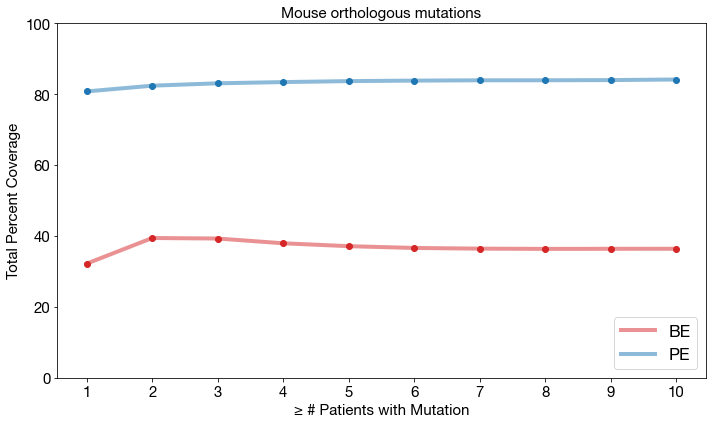

In [110]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1,11), be, linewidth=4, alpha=0.5, c='tab:red', label='BE')
plt.scatter(range(1,11), be, c='tab:red')
plt.plot(range(1,11), pe, linewidth=4, alpha=0.5, c='tab:blue', label='PE')
plt.scatter(range(1,11), pe, c='tab:blue')
plt.legend(loc='lower right', fontsize=17)
plt.ylim(0,100)
#plt.xlabel('', fontsize=15)
#plt.ylabel('', fontsize=15)
plt.xlabel('≥ # Patients with Mutation', fontsize=15)
plt.ylabel('Total Percent Coverage', fontsize=15)
plt.title('Mouse orthologous mutations', fontsize=15)

plt.xticks(range(1,11), fontsize=15)
plt.yticks(fontsize=15);

#ax.set_xticklabels(['','','','','','','','','',''])
#ax.set_yticklabels(['','','','','',''])


plt.tight_layout()
#plt.savefig('mouse_PE_BE_nolabels.png', dpi=250)

# Flank Size/Orthology Threshold Analysis

Capabilities of prime editing and base editing to model orthologous mutations in mice as a function of flank size (i.e. stringency of homology). 


Flank size is defined as the number of amino acids on either side of the mutant codon that must match between the human and mouse orthologs for the mutation to be considered orthologous (e.g. flank size of 2 would mean that a total of 5 amino acids–2 upstream and 2 downstream of the mutant codon–would need to match in the human and mouse protein to be considered orthologous). 



In [146]:
flank_size=5
i = flank_size
df = pd.read_csv(path+'flanksize_' + str(i) +'.csv')
mut_types = np.unique(df['variant_type'])

df['CBEproto']=CBEproto
df['CBEideal']=CBEideal
df['ABEproto']=ABEproto
df['ABEideal']=ABEideal
df['BE_total'] = CBEproto+ABEproto

df['PEcover_rt30'] = cover_list[29]

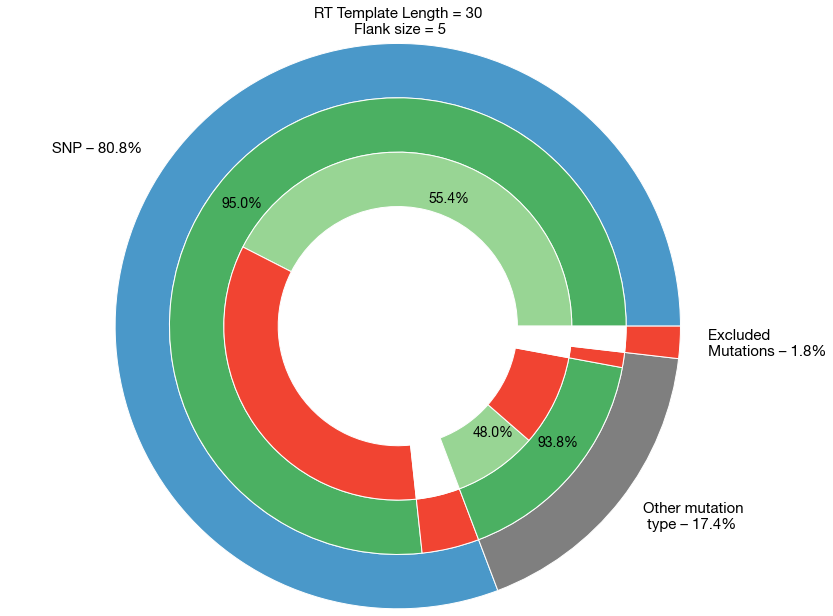

In [147]:
##generating dataframe
min_patients=1

atleast2 = result[result['num_occur']>=min_patients]
index2 = np.array(atleast2['indeces'])
idx_list = []
for i in index2: #lazy way of doing this...
    ints = re.findall(r'\d+', i)
    for k in ints:
        idx_list.append(int(k))

idx_list = np.unique(idx_list)

recur_binary = np.zeros(len(df))
for i in idx_list:
    recur_binary[i]+=1
    
df['recur']=recur_binary

recurrent = df[df['recur']==1]

###plotting
snps = recurrent[recurrent['variant_type']=='SNP']
snps_true = snps[snps['excluded_mutations']==0]

non_snps = recurrent[recurrent['variant_type']!='SNP']
non_snps_true = non_snps[non_snps['excluded_mutations']==0]

excl = sum(recurrent['excluded_mutations'])
snps_perc = np.round(100*len(snps_true)/len(recurrent), 1)
excl_perc = np.round(100*excl/len(recurrent), 1)
non_snps_perc = np.round(100*(len(recurrent)-excl-len(snps_true))/len(recurrent), 1)


#alternate version
group_names=['SNP – ' + str(snps_perc) + '%', 'Other mutation \n type – ' + str(non_snps_perc) + '%', 'Excluded \nMutations – '+ str(excl_perc) + '%'] #
#group_names = ['','','']
snp_unrecorded = []
group_size=[len(snps_true), len(non_snps_true), excl] #excluding missing SNPs

snps_coding = sum(np.array(snps_true['coding_mutations']))
snp_noncoding = sum(np.array(snps_true['non_coding_mutations']))

non_snps_coding = sum(np.array(non_snps_true['coding_mutations']))
non_snps_noncoding = sum(np.array(non_snps_true['non_coding_mutations']))

subgroup_size = [snps_coding,snp_noncoding, non_snps_coding,non_snps_noncoding, excl]
snpprct = np.round(100*snps_coding/len(snps_true), 1)
nsnpprct = np.round(100*non_snps_coding/len(non_snps_true), 1)
subgroup_names=[str(snpprct) + '%', '', str(nsnpprct) + '%', '', '']
#subgroup_names=['', '', '', '', '']

 
    
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray',b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.25, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.25, labels=subgroup_names, labeldistance=0.80, colors=[c(0.6), b(0.6), c(0.6), b(0.6), 'white'], textprops={'fontsize': 14})
plt.setp( mypie2, width=0.25, edgecolor='white')
plt.margins(0,0)

#third ring (smalles)
homo_snp = snps_true[snps_true['homologous']==1]
homo_and_model = homo_snp[homo_snp['PEcover_rt30']==1]
homo_nonsnp = non_snps_true[non_snps_true['homologous']==1]
homo_and_model_ns = homo_nonsnp[homo_nonsnp['PEcover_rt30']==1]

snps_homo = sum(np.array(homo_and_model['homologous']))
snps_nonhomo = snps_coding - snps_homo
non_snps_homo = sum(np.array(homo_and_model_ns['homologous']))
non_snps_nonhomo = non_snps_coding - non_snps_homo

snp_perc1 = np.round(100*snps_homo/(snps_homo+snps_nonhomo),1)
non_snp_perc1 = np.round(100*non_snps_homo/(non_snps_homo+non_snps_nonhomo),1)

subgroup_size2 = [snps_homo, snps_nonhomo, snp_noncoding,  non_snps_homo, non_snps_nonhomo, non_snps_noncoding, excl]
subgroup_names2=[str(snp_perc1) + '%', '','', str(non_snp_perc1) + '%', '','', '']
#subgroup_names2=['', '','', '', '','', '']




mypie3, _ = ax.pie(subgroup_size2, radius=1.3-0.5, labels=subgroup_names2, labeldistance=0.75, colors=[c(0.4), b(0.6),'white', c(0.4), b(0.6), 'white', 'white'], textprops={'fontsize': 14})
plt.setp( mypie3, width=0.25, edgecolor='white')
plt.margins(0,0)
#plt.legend()
 
# show it
#plt.tight_layout()
ax.set_title('RT Template Length = 30\n Flank size = ' + str(flank_size), pad=20, fontsize=15)


plt.show()

#fig.savefig('PE_donut_recur_flank_nolabel_' + str(flank_size)+'.png', dpi=250)

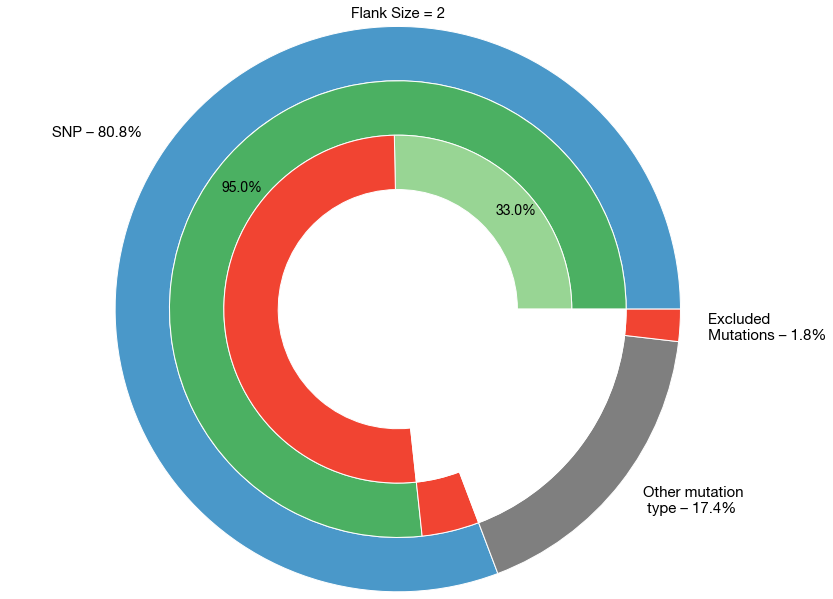

In [138]:
flank_size=2
i = flank_size
df = pd.read_csv(path+'flanksize_' + str(i) +'.csv')
mut_types = np.unique(df['variant_type'])

df['CBEproto']=CBEproto
df['CBEideal']=CBEideal
df['ABEproto']=ABEproto
df['ABEideal']=ABEideal
df['BE_total'] = CBEproto+ABEproto

df['PEcover_rt30'] = cover_list[29]

##generating dataframe
min_patients=1

atleast2 = result[result['num_occur']>=min_patients]
index2 = np.array(atleast2['indeces'])
idx_list = []
for i in index2: #lazy way of doing this...
    ints = re.findall(r'\d+', i)
    for k in ints:
        idx_list.append(int(k))

idx_list = np.unique(idx_list)

recur_binary = np.zeros(len(df))
for i in idx_list:
    recur_binary[i]+=1
    
df['recur']=recur_binary

recurrent = df[df['recur']==1]

###plotting
snps = recurrent[recurrent['variant_type']=='SNP']
snps_true = snps[snps['excluded_mutations']==0]

non_snps = recurrent[recurrent['variant_type']!='SNP']
non_snps_true = non_snps[non_snps['excluded_mutations']==0]

excl = sum(recurrent['excluded_mutations'])
snps_perc = np.round(100*len(snps_true)/len(recurrent), 1)
excl_perc = np.round(100*excl/len(recurrent), 1)
non_snps_perc = np.round(100*(len(recurrent)-excl-len(snps_true))/len(recurrent), 1)


#alternate version
group_names=['SNP – ' + str(snps_perc) + '%', 'Other mutation \n type – ' + str(non_snps_perc) + '%', 'Excluded \nMutations – '+ str(excl_perc) + '%'] #
#group_names=['','','']


snp_unrecorded = []
group_size=[len(snps_true), len(non_snps_true), excl] #excluding missing SNPs

snps_coding = sum(np.array(snps_true['coding_mutations']))
snp_noncoding = sum(np.array(snps_true['non_coding_mutations']))

non_snps_coding = sum(np.array(non_snps_true['coding_mutations']))
non_snps_noncoding = sum(np.array(non_snps_true['non_coding_mutations']))

subgroup_size = [snps_coding,snp_noncoding, non_snps_coding,non_snps_noncoding, excl]
snpprct = np.round(100*snps_coding/len(snps_true), 1)
nsnpprct = np.round(100*non_snps_coding/len(non_snps_true), 1)
subgroup_names=[str(snpprct) + '%', '', '', '', '']
#subgroup_names=['', '', '', '', '']


# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray',b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.25, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.25, labels=subgroup_names, labeldistance=0.80, colors=[c(0.6), b(0.6), 'white', 'white', 'white'], textprops={'fontsize': 14})
plt.setp( mypie2, width=0.25, edgecolor='white')
plt.margins(0,0)

#third ring (smalles)
homo_snp = snps_true[snps_true['homologous']==1]
homo_and_model = homo_snp[homo_snp['BE_total']==1]
homo_nonsnp = non_snps_true[non_snps_true['homologous']==1]
homo_and_model_ns = homo_nonsnp[homo_nonsnp['PEcover_rt30']==1]

snps_homo = sum(np.array(homo_and_model['homologous']))
snps_nonhomo = snps_coding - snps_homo
non_snps_homo = sum(np.array(homo_and_model_ns['homologous'])) #these are inaccurate but doesn't matter
non_snps_nonhomo = non_snps_coding - non_snps_homo

snp_perc1 = np.round(100*snps_homo/(snps_homo+snps_nonhomo),1)
non_snp_perc1 = np.round(100*non_snps_homo/(non_snps_homo+non_snps_nonhomo),1)

subgroup_size2 = [snps_homo, snps_nonhomo, snp_noncoding,  non_snps_homo, non_snps_nonhomo, non_snps_noncoding, excl]
subgroup_names2=[str(snp_perc1) + '%', '','', '', '','', '']
#subgroup_names2=['', '','', '', '','', '']




mypie3, _ = ax.pie(subgroup_size2, radius=1.3-0.5, labels=subgroup_names2, labeldistance=0.8, colors=[c(0.4), b(0.6),'white', 'white', 'white', 'white', 'white'], textprops={'fontsize': 14})
plt.setp( mypie3, width=0.25, edgecolor='white')
plt.margins(0,0)
#plt.legend()
 
# show it
#plt.tight_layout()
ax.set_title('Flank Size = ' + str(flank_size), pad=20, fontsize=15)


plt.show()

#fig.savefig('BE_donut_recur_flank_nolabel_' + str(flank_size)+'.png', dpi=250)

In [337]:
pe = []
be = []
for flank_size in range(21):
    
    df = pd.read_csv(path+'flanksize_' + str(flank_size) +'.csv')
    mut_types = np.unique(df['variant_type'])

    df['CBEproto']=CBEproto
    df['CBEideal']=CBEideal
    df['ABEproto']=ABEproto
    df['ABEideal']=ABEideal
    df['BE_total'] = CBEproto+ABEproto

    df['PEcover_rt30'] = cover_list[29]
    
    min_patients=1
    
    atleast2 = result[result['num_occur']>=min_patients]
    index2 = np.array(atleast2['indeces'])
    idx_list = []
    for i in index2: #lazy way of doing this...
        ints = re.findall(r'\d+', i)
        for k in ints:
            idx_list.append(int(k))

    idx_list = np.unique(idx_list)

    recur_binary = np.zeros(len(df))
    for i in idx_list:
        recur_binary[i]+=1

    df['recur']=recur_binary

    recurrent = df[df['recur']==1]


    snps = recurrent[recurrent['variant_type']=='SNP']
    snps_true = snps[snps['excluded_mutations']==0]

    non_snps = recurrent[recurrent['variant_type']!='SNP']
    non_snps_true = non_snps[non_snps['excluded_mutations']==0]

    ##calculation for BE perc coverage
    homo_snp = snps_true[snps_true['homologous']==1]
    homo_and_model_BE = homo_snp[homo_snp['BE_total']==1]
    BE_snps_homo = sum(np.array(homo_and_model_BE['homologous']))
    BE_cover = 100*BE_snps_homo/len(recurrent)

    ##calculation for PE perc coverage
    homo_and_model = homo_snp[homo_snp['PEcover_rt30']==1]
    homo_nonsnp = non_snps_true[non_snps_true['homologous']==1]
    homo_and_model_ns = homo_nonsnp[homo_nonsnp['PEcover_rt30']==1]

    snps_homo = sum(np.array(homo_and_model['homologous']))
    non_snps_homo = sum(np.array(homo_and_model_ns['homologous']))
    PE_cover = 100*(snps_homo+non_snps_homo)/len(recurrent)

    be.append(BE_cover)
    pe.append(PE_cover)

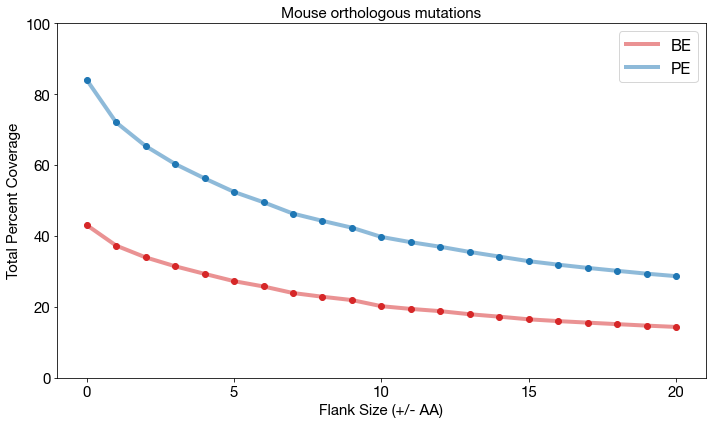

In [341]:
plt.figure(figsize=(10,6))
plt.plot(range(0,21), be, linewidth=4, alpha=0.5, c='tab:red', label='BE')
plt.scatter(range(0,21), be, c='tab:red')
plt.plot(range(0,21), pe, linewidth=4, alpha=0.5, c='tab:blue', label='PE')
plt.scatter(range(0,21), pe, c='tab:blue')
plt.legend(fontsize=16)
plt.ylim(0,100)
plt.xlabel('Flank Size (+/- AA)', fontsize=15)
plt.ylabel('Total Percent Coverage', fontsize=15)
plt.title('Mouse orthologous mutations', fontsize=15)

plt.xticks(range(0,21, 5), fontsize=15)
plt.yticks(fontsize=15);
plt.tight_layout()
plt.savefig('mouse_PE_BE_flank_size5.png', dpi=250)